In [1]:
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import euclidean_distances
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
sns.set()
import networkx as nx
from apyori import apriori
from itertools import combinations
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 2. Import Dataset

In [2]:
# Import order product dataset
order_products = pd.read_csv('order_products.csv')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,10,24,1,1
1,10,83,2,1
2,10,16,3,0
3,10,24,4,1
4,10,83,5,1


In [3]:
# Import products dataset
products = pd.read_csv('products.csv')
products.head()

,product_id,department_id,product_name
0,61,19,cookies cakes
1,104,13,spices seasonings
2,94,7,tea
3,38,1,frozen meals
4,5,13,marinades meat preparation


In [4]:
# Import departments dataset
departments = pd.read_csv('departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
# Import orders dataset
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,18,NaN
1,1944304,162867,1,3,17,NaN
2,1201011,147243,14,0,16,3.0
3,1906860,195275,81,1,11,3.0
4,2766469,58222,3,6,11,6.0


In [6]:
orders.shape

(200000, 6)

In [7]:
# Find orders that its users didn't have order before
# New Customers
new_customers_order = orders.loc[orders['days_since_prior_order'].isna()]

In [8]:
new_customers_order.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,18,NaN
1,1944304,162867,1,3,17,NaN
6,1378095,73110,1,6,10,NaN
12,763857,195070,1,5,2,NaN
46,49056,14451,1,1,11,NaN


# 3. Data Preparation 
## 3.1 Missing Values

In [9]:
#Check of missing values in all datasets
order_products_out = order_products.isnull().sum().sort_values(ascending=False)
products_out = products.isnull().sum().sort_values(ascending=False)
departments_out = departments.isnull().sum().sort_values(ascending=False)
orders_out = orders.isnull().sum().sort_values(ascending=False)


print('Missing Values of order products: \n',order_products_out, '\n',
     'Missing Values of produtcts: \n',products_out, '\n',
      'Missing Values of departments: \n',departments_out, '\n',
     'Missing Values of orders: \n',orders_out)

Missing Values of order products: 
 reordered            0
add_to_cart_order    0
product_id           0
order_id             0
dtype: int64 
 Missing Values of produtcts: 
 product_name     0
department_id    0
product_id       0
dtype: int64 
 Missing Values of departments: 
 department       0
department_id    0
dtype: int64 
 Missing Values of orders: 
 days_since_prior_order    12254
order_hour_of_day             0
order_dow                     0
order_number                  0
user_id                       0
order_id                      0
dtype: int64


In [10]:
#Check the percentage of missing values in column 'days_since_prior_order' in orders dataset
orders_out = orders['days_since_prior_order'].isnull().sum()/orders['days_since_prior_order'].count()
orders_out*100

6.526903369445954

# 4. Overview

In [11]:
# Check the number of unique products and unique orders
orders_unique = len(set(orders.order_id))
products_unique = len(set(products.product_id))

print("There are %s orders for %s products " %(orders_unique,products_unique))

There are 200000 orders for 134 products 


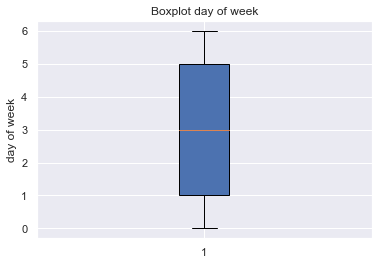

In [12]:
# Plot distribution hour of the day 
plt.boxplot(orders.order_dow, patch_artist=True)
plt.title('Boxplot day of week')
plt.ylabel('day of week');

## Orders and Products counts by user

In [13]:
orders_by_user = orders.groupby('user_id')['order_number'].max()
orders_by_user.head()

user_id
2      3
3     11
7      3
10     4
11     5
Name: order_number, dtype: int64

In [14]:
# Calculate Minimum and Maximum order
min_ord= min(orders_by_user)
max_ord= max(orders_by_user)
print("The maximum orders by user is {} and the minimum orders by user is {} " .format(max_ord, min_ord))

The maximum orders by user is 100 and the minimum orders by user is 1 


In [15]:
# Make a new dataframe based on orders and order_products
products_by_user = orders[['order_id', 'user_id']].merge(
    order_products[['order_id', 'add_to_cart_order']]
    .groupby('order_id').max().rename({'add_to_cart_order': 'size_of_order'}, axis = 1),
    on = 'order_id')

In [16]:
products_by_user.head()

,order_id,user_id,size_of_order
0,2425083,49125,9
1,1944304,162867,13
2,1201011,147243,15
3,1906860,195275,11
4,2766469,58222,15


In [17]:
# Drop order_id and make a dataframe for sum of order_size of each user
products_by_user = products_by_user.drop('order_id', axis = 1).groupby('user_id')['size_of_order'].sum()

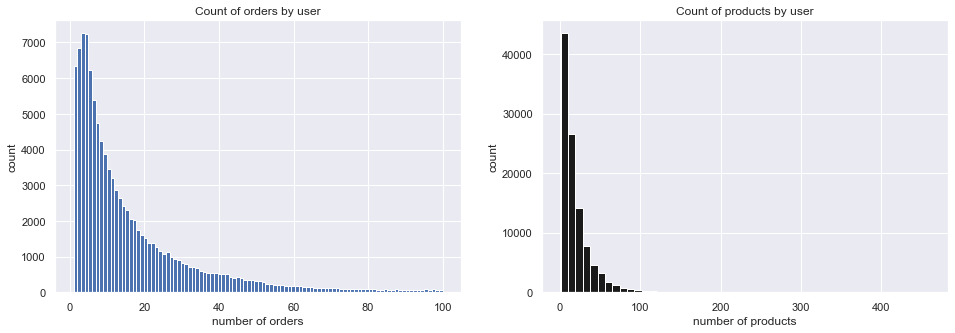

In [18]:
# Plot Histogram of orders and products counts by user
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].hist(orders_by_user, bins = 100)
ax[0].set_title('Count of orders by user')
ax[0].set_xlabel('number of orders')
ax[0].set_ylabel('count')

ax[1].hist(products_by_user, bins = 50, color='k')
ax[1].set_title('Count of products by user')
ax[1].set_xlabel('number of products')
ax[1].set_ylabel('count');

## Number of orders by order number

In [19]:
# Make a dataframe based on number of order_number
orders_by_order_number = orders.order_number.value_counts()
orders_by_order_number.head()

2    12325
1    12254
3    12218
4    11896
5    10471
Name: order_number, dtype: int64

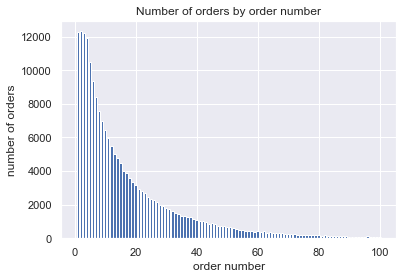

In [20]:
# Plot histogram of order_number
plt.bar(orders_by_order_number.index, orders_by_order_number)
plt.title('Number of orders by order number')
plt.xlabel('order number')
plt.ylabel('number of orders');

## Number of products and orders by the day of the week

In [21]:
# Make bins based on day of the week
orders_by_dow = orders.order_dow.value_counts()
orders_by_dow

0    35078
1    34348
2    27277
5    26557
6    26096
3    25670
4    24974
Name: order_dow, dtype: int64

In [22]:
# Make a dataframe of products based on day of the week by merging orders and order_products
products_by_dow = orders[['order_id', 'order_dow']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id'
)

In [23]:
# Drop order_id from dataframe and group by day of the week
products_by_dow = products_by_dow.drop('order_id', axis=1).groupby('order_dow')['order_size'].sum()

In [24]:
days=['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

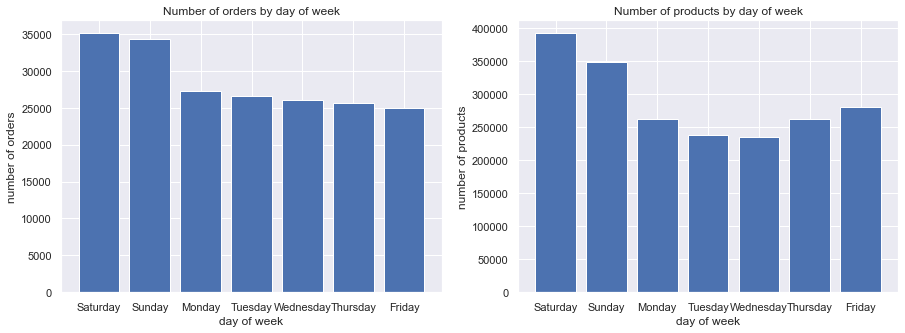

In [25]:
# Plot number of products and orders by the day of the week
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(days, orders_by_dow)
ax[0].set_title('Number of orders by day of week')
ax[0].set_xlabel('day of week')
ax[0].set_ylabel('number of orders')

ax[1].bar(days, products_by_dow)
ax[1].set_title('Number of products by day of week')
ax[1].set_xlabel('day of week')
ax[1].set_ylabel('number of products');

In [26]:
# Define a function to seperate weekends
def dow(dow):
  if dow in [0, 1]:
    return 'weekend'
  else:
    return 'weekday'

## Number of orders and products per hour

In [27]:
# Count of orders per hour
orders_by_hour = orders.order_hour_of_day.value_counts()

In [28]:
# Make a dataset for products per hour
products_by_hour = orders[['order_id', 'order_hour_of_day']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id'
)
products_by_hour = products_by_hour.drop('order_id', axis = 1).groupby('order_hour_of_day')['order_size'].sum()

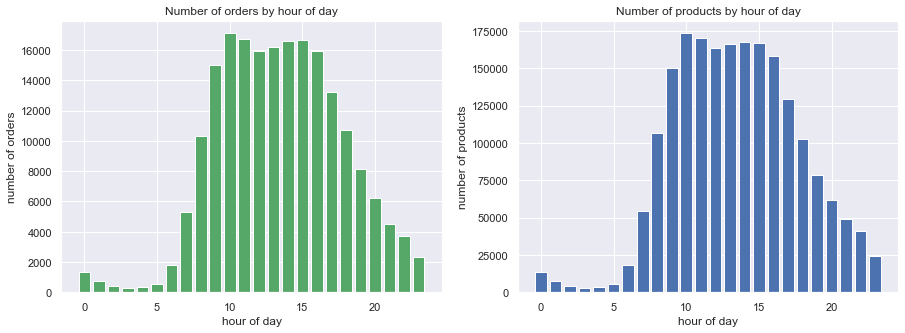

In [29]:
# Plot number of orders and products per hour
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(orders_by_hour.index, orders_by_hour, color='g')
ax[0].set_title('Number of orders by hour of day')
ax[0].set_xlabel('hour of day')
ax[0].set_ylabel('number of orders')

ax[1].bar(products_by_hour.index, products_by_hour, color='b')
ax[1].set_title('Number of products by hour of day')
ax[1].set_xlabel('hour of day')
ax[1].set_ylabel('number of products');

## Number of orders with x days since the last purchase

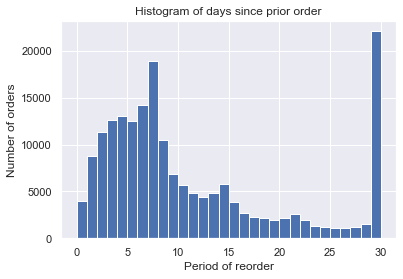

In [30]:
# Plot histogram for days since the last purchase
plt.hist(orders.days_since_prior_order, bins = 30)
plt.title('Histogram of days since prior order')
plt.xlabel('Period of reorder')
plt.ylabel('Number of orders');

## Products tried once and reordered

In [31]:
# Make a dictionary to map product id to its name
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}
#print(products_id_to_name)

In [32]:
# Replace product id into name
order_products_names = order_products.copy()
order_products_names['product_name'] = order_products_names.product_id.map(lambda x: products_id_to_name[x])
order_products_names.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name
0,10,24,1,1,fresh fruits
1,10,83,2,1,fresh vegetables
2,10,16,3,0,fresh herbs
3,10,24,4,1,fresh fruits
4,10,83,5,1,fresh vegetables
5,10,16,6,0,fresh herbs
6,10,24,7,1,fresh fruits
7,10,92,8,1,baby food formula
8,10,92,9,1,baby food formula
9,10,59,10,0,canned meals beans


In [33]:
# Calculate the reorder times of each product
reorder_proportion = pd.crosstab(order_products_names.product_name, order_products_names.reordered)
# Sort products not reordered descending. So we have popular products that have been tried once
reorder_proportion.sort_values(by = 0, ascending=False).head()

reordered,0,1
product_name,,
fresh vegetables,86440,126171
fresh fruits,63684,162355
packaged vegetables fruits,39724,69872
yogurt,28287,62464
packaged cheese,25638,35864


In [34]:
# Sort products reordered descending. So we have popular products that have been reordered
reorder_proportion.sort_values(by = 1, ascending=False).head()

reordered,0,1
product_name,,
fresh fruits,63684,162355
fresh vegetables,86440,126171
packaged vegetables fruits,39724,69872
yogurt,28287,62464
milk,11988,43162


## Count of order size

In [35]:
# Products numbers added to cart 
cart_size = order_products.groupby('order_id')['add_to_cart_order'].max()
cart_size

order_id
10         15
11          5
28         16
38          9
56         10
           ..
3420991    13
3421019     3
3421027    12
3421074     4
3421080     9
Name: add_to_cart_order, Length: 200000, dtype: int64

In [36]:
# Size of each cart counted in bins
cart_size = cart_size.value_counts()
cart_size

5      14242
6      14146
4      13760
7      13695
8      12741
       ...  
77         1
100        1
66         1
65         1
109        1
Name: add_to_cart_order, Length: 82, dtype: int64

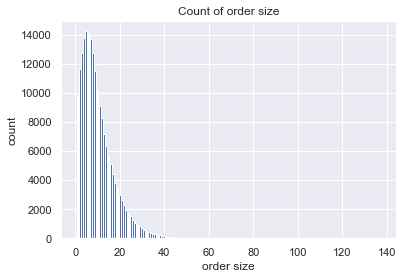

In [37]:
# Plot histogram of cart size
plt.bar(cart_size.index, cart_size)
plt.title('Count of order size')
plt.xlabel('order size')
plt.ylabel('count');

## Most requested products taking into account the number of items purchased

In [38]:
# Make a dataframe of each product with number of added to cart
add_to_cart = pd.crosstab(order_products_names.product_name, order_products_names.add_to_cart_order)
add_to_cart.head(5)

add_to_cart_order,1,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
product_name,,,,,,,,,,,,,,,,,,,,,
air fresheners candles,105,103,106,101,95,100,101,65,54,54,...,0,0,0,0,0,0,0,0,0,0
asian foods,809,791,788,750,686,663,635,574,519,428,...,0,0,0,0,0,0,0,0,0,0
baby accessories,39,48,47,42,38,35,30,21,18,18,...,0,0,0,0,0,0,0,0,0,0
baby bath body care,49,34,34,36,32,35,27,25,27,18,...,0,0,0,0,0,0,0,0,0,0
baby food formula,1145,1283,1453,1586,1563,1456,1439,1353,1266,1176,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#Most requested products taking into account the number of items purchased
for i in range(1,5):
  print('Buy', i, 'products')
  print(add_to_cart.sort_values(by = i, ascending=False)[i][:5])  
  print('\n')

Buy 1 products
product_name
fresh fruits                     27806
fresh vegetables                 14858
milk                             11834
water seltzer sparkling water    10148
packaged vegetables fruits        8663
Name: 1, dtype: int64


Buy 2 products
product_name
fresh fruits                  26382
fresh vegetables              16320
packaged vegetables fruits     9360
yogurt                         8917
milk                           8459
Name: 2, dtype: int64


Buy 3 products
product_name
fresh fruits                  23506
fresh vegetables              17104
packaged vegetables fruits     9549
yogurt                         8923
milk                           6366
Name: 3, dtype: int64


Buy 4 products
product_name
fresh fruits                  20740
fresh vegetables              16882
packaged vegetables fruits     9165
yogurt                         8219
milk                           4915
Name: 4, dtype: int64




## Most important Departments (by number of products)


In [40]:
items  = pd.merge(left=products, right=departments, how='left')
items.head()

,product_id,department_id,product_name,department
0,61,19,cookies cakes,snacks
1,104,13,spices seasonings,pantry
2,94,7,tea,beverages
3,38,1,frozen meals,frozen
4,5,13,marinades meat preparation,pantry


In [41]:
grouped = items.groupby("department")["product_id"].aggregate('count').reset_index()
grouped = grouped.rename(columns={"product_id" : "total_products"})
grouped['Ratio'] = grouped["total_products"].apply(lambda x: x /grouped['total_products'].sum())
grouped.sort_values(by='total_products', ascending=False, inplace=True)
grouped

,department,total_products,Ratio
17,personal care,17,0.126866
16,pantry,12,0.089552
10,frozen,11,0.082090
20,snacks,11,0.082090
7,dairy eggs,10,0.074627
11,household,10,0.074627
3,beverages,8,0.059701
13,meat seafood,7,0.052239
0,alcohol,5,0.037313
6,canned goods,5,0.037313


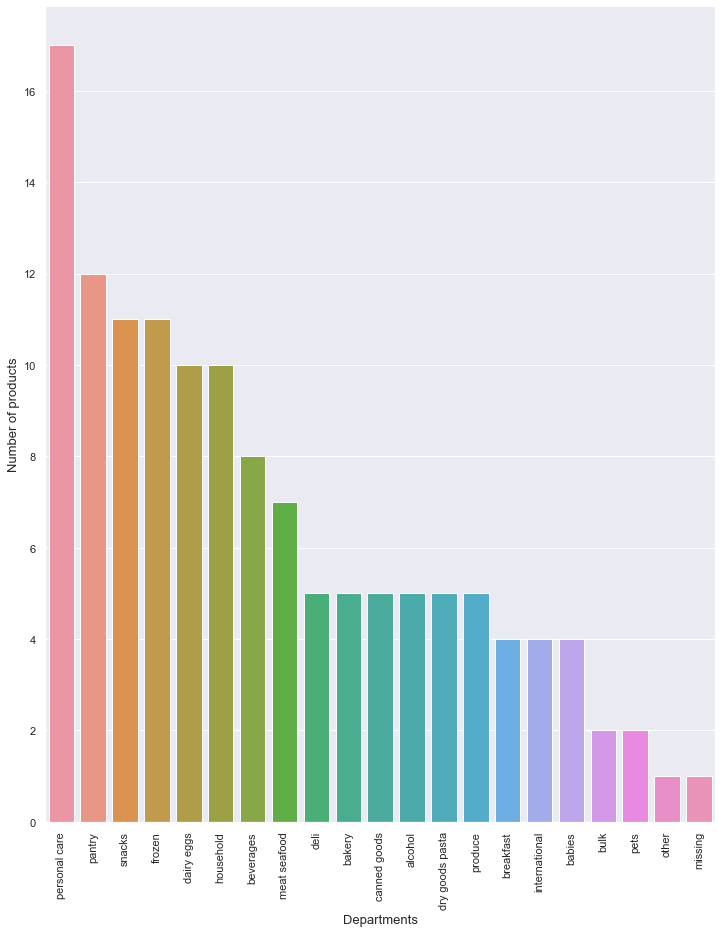

In [42]:
grouped  = grouped.groupby(['department']).sum()['total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

## Best Selling Departments (number of Orders)

In [43]:
users_flow = orders[['user_id', 'order_id']].merge(order_products[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')

users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

In [44]:
grouped = users_flow.groupby("department")["order_id"].aggregate('count').reset_index()
grouped = grouped.rename(columns={"order_id" : "total_orders"})
grouped['Ratio'] = grouped["total_orders"].apply(lambda x: x /grouped['total_orders'].sum())
grouped.sort_values(by='total_orders', ascending=False, inplace=True)
grouped

,department,total_orders,Ratio
19,produce,588996,0.291654
7,dairy eggs,336915,0.166831
20,snacks,180692,0.089474
3,beverages,168126,0.083251
10,frozen,139536,0.069094
16,pantry,116262,0.057570
2,bakery,72983,0.036139
6,canned goods,66053,0.032708
8,deli,65176,0.032273
9,dry goods pasta,54054,0.026766


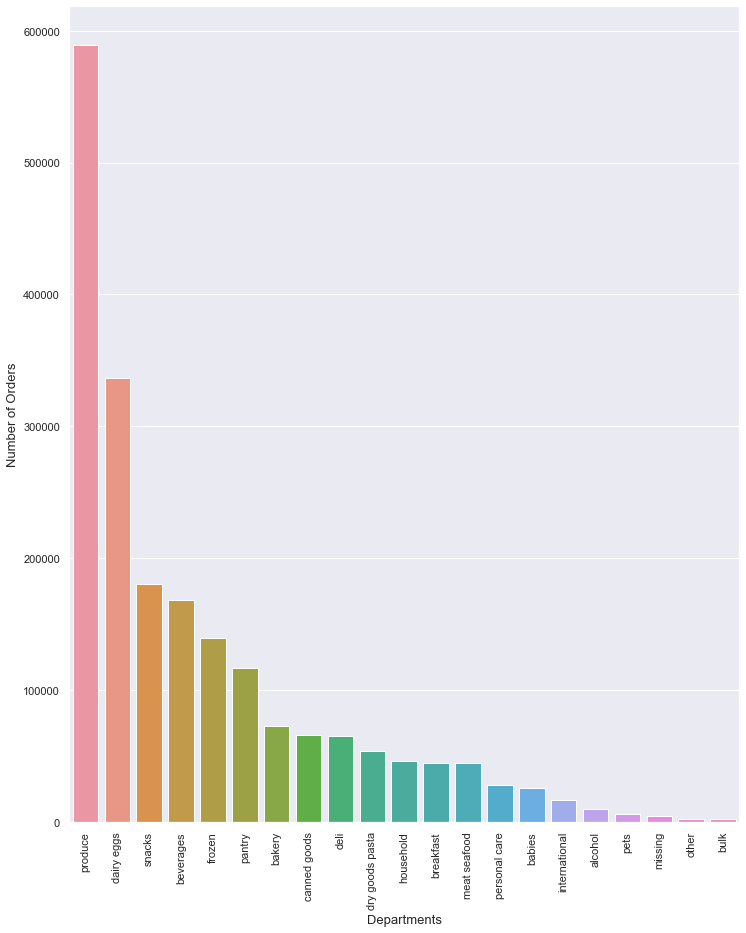

In [45]:
grouped  = grouped.groupby(['department']).sum()['total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

# 5. What are the main types of consumer behavior in the business?

## Clustering with K-Means

In [46]:
products_reordered=products.merge(order_products,on='product_id')
products_reordered

,product_id,department_id,product_name,order_id,add_to_cart_order,reordered
0,61,19,cookies cakes,1083,9,0
1,61,19,cookies cakes,1691,1,1
2,61,19,cookies cakes,1951,41,0
3,61,19,cookies cakes,2199,14,1
4,61,19,cookies cakes,2432,2,1
...,...,...,...,...,...,...
2019496,76,6,indian foods,2940031,17,0
2019497,76,6,indian foods,2993615,7,0
2019498,76,6,indian foods,2999003,4,0
2019499,76,6,indian foods,3069391,12,0


In [47]:
consumer_behaviour=products_reordered.merge(orders, on='order_id')
segmentation = pd.crosstab(consumer_behaviour.user_id,consumer_behaviour.product_name)
segmentation = segmentation.div(segmentation.sum(axis=1), axis=0)

In [48]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(segmentation)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,0.086824,-0.161613,-0.028145,-0.013105,-0.060570,-0.048842,-0.039020,-0.063265,0.141543,0.050241
1,0.003981,-0.097846,0.003631,-0.058412,0.099325,-0.056562,-0.017472,-0.030245,-0.005114,0.025907
2,-0.082569,-0.005921,-0.055186,0.018260,-0.035472,-0.022051,-0.033946,-0.056055,-0.036593,-0.097516
3,-0.006792,0.048308,-0.038930,-0.019814,0.052433,-0.018718,-0.017893,-0.025417,0.094738,0.048682
4,-0.166932,-0.034989,0.111684,-0.089711,0.038502,0.045622,-0.014616,0.064886,0.004059,-0.003978


In [49]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

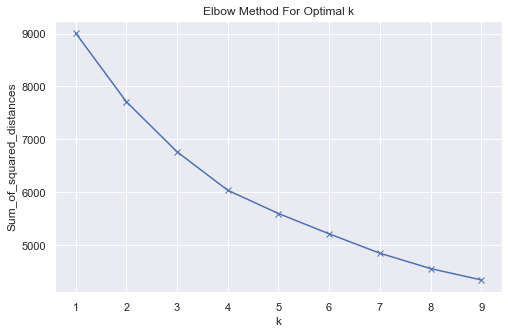

In [50]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [51]:
cluster = KMeans(n_clusters=4,random_state=42).fit(df_pca)
centers = cluster.cluster_centers_
c_preds = cluster.predict(df_pca)
print(centers)

[[-7.47198002e-02 -1.99097380e-02 -3.22273222e-02  6.64849576e-05
  -7.09667388e-04 -3.30721204e-03 -1.84963833e-03 -2.51848592e-03
   3.99975256e-04 -5.54348976e-04]
 [ 1.01972268e-01  1.55924305e-01  2.22589442e-02  1.28094585e-03
  -1.74764252e-03  4.28215701e-03  1.45692497e-03  3.27239015e-03
  -6.57008225e-04 -8.92517320e-05]
 [ 1.78963321e-01 -1.59826467e-01  1.28921928e-02 -6.02580816e-03
   3.76409198e-04  3.76136856e-03  2.11527301e-03  3.86393734e-03
  -8.61765442e-04  1.12321950e-03]
 [-2.36004713e-01 -7.71753879e-02  4.78556807e-01  2.13335066e-02
   3.12379784e-02  1.59580990e-02  1.77592516e-02  6.22603431e-03
   1.75822265e-03  7.46639687e-03]]


In [52]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

,pc1,pc2,cluster
0,0.086824,-0.161613,2
1,0.003981,-0.097846,0
2,-0.082569,-0.005921,0
3,-0.006792,0.048308,0
4,-0.166932,-0.034989,0


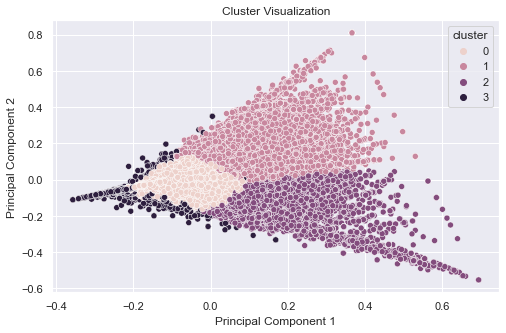

In [53]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [54]:
segmentation['cluster'] = c_preds

cluster1 = segmentation[segmentation.cluster == 0]
cluster2 = segmentation[segmentation.cluster == 1]
cluster3 = segmentation[segmentation.cluster == 2]
cluster4 = segmentation[segmentation.cluster == 3]


"\ntemp_df['cluster'] = c_preds\n\ncluster1 = segmentation[segmentation.cluster == 0]\ncluster2 = segmentation[segmentation.cluster == 1]\ncluster3 = segmentation[segmentation.cluster == 2]\ncluster4 = segmentation[segmentation.cluster == 3]\n\n"

In [55]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh fruits                     0.054393
yogurt                           0.044824
packaged vegetables fruits       0.043114
fresh vegetables                 0.034451
milk                             0.032986
packaged cheese                  0.031667
chips pretzels                   0.028406
water seltzer sparkling water    0.024591
ice cream ice                    0.022596
soft drinks                      0.022267
dtype: float64

In [56]:
cluster1.shape

(62389, 135)

In [57]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh vegetables                 0.276276
fresh fruits                     0.110345
packaged vegetables fruits       0.066818
yogurt                           0.028825
packaged cheese                  0.024877
fresh herbs                      0.022311
milk                             0.021428
soy lactosefree                  0.018327
water seltzer sparkling water    0.016829
frozen produce                   0.015890
dtype: float64

In [58]:
cluster2.shape

(24940, 135)

In [59]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
fresh fruits                     0.342031
packaged vegetables fruits       0.066248
fresh vegetables                 0.051904
packaged produce                 0.037022
yogurt                           0.036136
milk                             0.030853
water seltzer sparkling water    0.020765
packaged cheese                  0.020596
soy lactosefree                  0.019959
frozen produce                   0.015562
dtype: float64

In [60]:
cluster3.shape

(15323, 135)

In [61]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

product_name
water seltzer sparkling water    0.559406
soft drinks                      0.039490
fresh fruits                     0.024735
yogurt                           0.014244
packaged produce                 0.013934
packaged vegetables fruits       0.013690
paper goods                      0.012333
milk                             0.011864
tea                              0.011761
chips pretzels                   0.011434
dtype: float64

In [62]:
cluster4.shape

(2621, 135)

# 6. Which types of products should have an extended amount of product offerings?

In [63]:
# Merge product labels
df = pd.merge(order_products, products, how='left', on='product_id').\
    drop(["product_id", "department_id", "add_to_cart_order", "reordered"], axis=1)
df.head()

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables


In [64]:
# Get modes and unique values
df.astype(object).describe()

,order_id,product_name
count,2019501,2019501
unique,200000,134
top,790903,fresh fruits
freq,137,226039


In [65]:
#The top 10 best-selling products
# Check product frequencies
df['product_name'].value_counts()[:10]

fresh fruits                     226039
fresh vegetables                 212611
packaged vegetables fruits       109596
yogurt                            90751
packaged cheese                   61502
milk                              55150
water seltzer sparkling water     52564
chips pretzels                    45306
soy lactosefree                   39389
bread                             36381
Name: product_name, dtype: int64

## Most ordered products

In [66]:
#the most ordered products
grouped = order_products.groupby("product_id")["reordered"].aggregate('count').reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.rename(columns={"reordered" : "total_reorders"})
grouped = grouped.sort_values(by='total_reorders', ascending=False)[:10]
grouped

,product_id,total_reorders,product_name
23,24,226039,fresh fruits
82,83,212611,fresh vegetables
122,123,109596,packaged vegetables fruits
119,120,90751,yogurt
20,21,61502,packaged cheese
83,84,55150,milk
114,115,52564,water seltzer sparkling water
106,107,45306,chips pretzels
90,91,39389,soy lactosefree
111,112,36381,bread


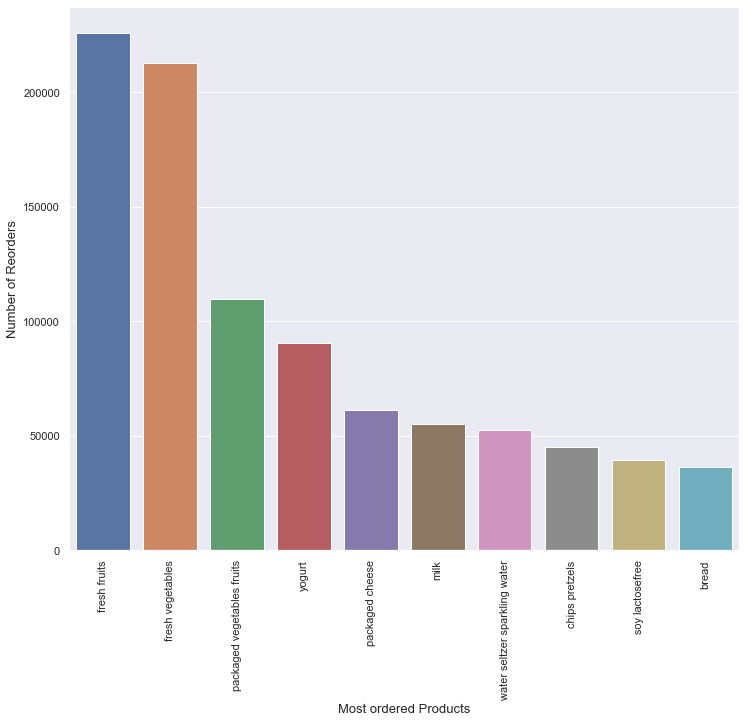

In [67]:
grouped  = grouped.groupby(['product_name']).sum()['total_reorders'].sort_values(ascending=False)


f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

## Reorder frequency

In [68]:
#reorder the same previous ordered products
grouped = order_products.groupby("reordered")["product_id"].aggregate('count').reset_index()
grouped = grouped.rename(columns={"product_id" : "total_products"})
grouped['Ratios'] = grouped["total_products"].apply(lambda x: x /grouped['total_products'].sum())
grouped

,reordered,total_products,Ratios
0,0,828515,0.410257
1,1,1190986,0.589743


<b>59%<b> of ordered products are previously ordered by customers

## Most reordered products

In [69]:
grouped = order_products.groupby("product_id")["reordered"].aggregate({sum, 'count'}).reset_index()
grouped = grouped.rename(columns={"count" : "reorder_total", "sum": "reorder_sum"})
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_total,reorder_sum,reorder_probability,product_name
83,84,55150,43162,0.782629,milk
114,115,52564,38467,0.731813,water seltzer sparkling water
23,24,226039,162355,0.718261,fresh fruits
85,86,27986,19798,0.707425,eggs
90,91,39389,27251,0.691843,soy lactosefree
31,32,17408,12021,0.690545,packaged produce
52,53,19786,13625,0.688618,cream
119,120,90751,62464,0.688301,yogurt
111,112,36381,24540,0.674528,bread
30,31,35893,23854,0.664586,refrigerated


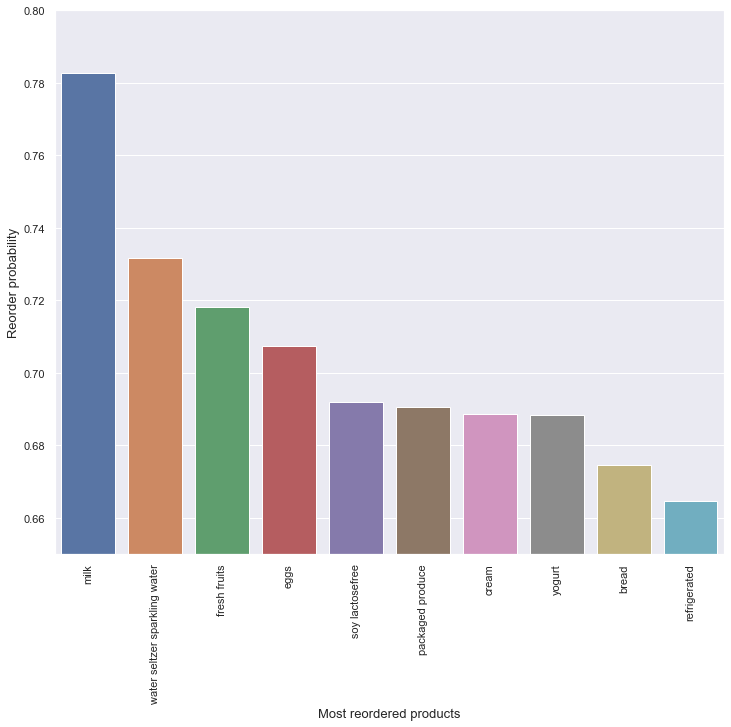

In [70]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=13)
plt.ylim([0.65,0.80])
plt.show()

## Most popular products

In [71]:
'''products_reordered=products.merge(order_products,on='product_id')
products_reordered'''

"products_reordered=products.merge(order_products,on='product_id')\nproducts_reordered"

In [72]:
temp_df = products_reordered.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

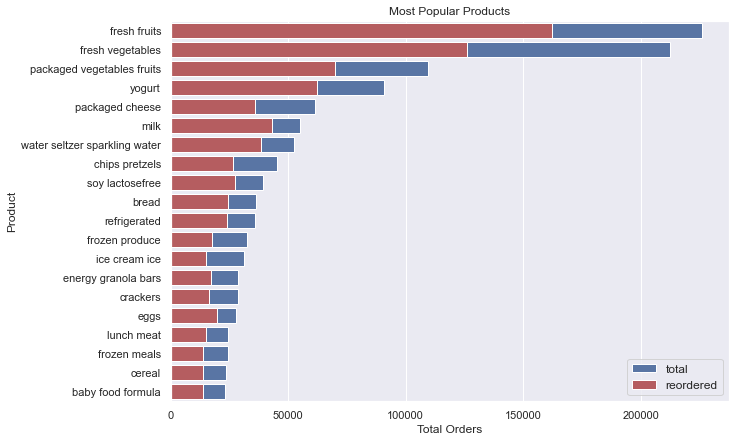

In [73]:
color = sns.color_palette()
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

# 7. Which items are complementary?

In [74]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)


In [76]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
64,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
125,"(fresh vegetables, yogurt, packaged vegetables...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
115,"(fresh vegetables, milk, packaged vegetables f...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
34,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
120,"(fresh vegetables, packaged cheese, packaged v...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,0.022750,2.667284


In [77]:
df_lift = association_rules(frequent_itemsets, metric='lift', min_threshold=1.8)[['antecedents','consequents','lift']].sort_values(by='lift',ascending=False).reset_index()
df_lift = df_lift.drop(columns='index')
df_lift

,antecedents,consequents,lift
0,"(fresh fruits, fresh vegetables)",(fresh herbs),2.092964
1,(fresh herbs),"(fresh fruits, fresh vegetables)",2.092964
2,(fresh vegetables),"(fresh fruits, fresh herbs)",1.983463
3,"(fresh fruits, fresh herbs)",(fresh vegetables),1.983463
4,"(fresh vegetables, yogurt)","(fresh fruits, packaged vegetables fruits)",1.952899
5,"(fresh fruits, packaged vegetables fruits)","(fresh vegetables, yogurt)",1.952899
6,(fresh herbs),(fresh vegetables),1.903203
7,(fresh vegetables),(fresh herbs),1.903203
8,"(packaged vegetables fruits, packaged cheese)","(fresh fruits, fresh vegetables)",1.877290
9,"(fresh fruits, fresh vegetables)","(packaged vegetables fruits, packaged cheese)",1.877290


In [78]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.8)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(fresh fruits, fresh vegetables)",(fresh herbs),0.317560,0.093005,0.061815,0.194656,2.092964,0.032280,1.126221
5,(fresh herbs),"(fresh fruits, fresh vegetables)",0.093005,0.317560,0.061815,0.664642,2.092964,0.032280,2.034958
4,(fresh vegetables),"(fresh fruits, fresh herbs)",0.444360,0.070135,0.061815,0.139110,1.983463,0.030650,1.080121
3,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
20,"(fresh vegetables, yogurt)","(fresh fruits, packaged vegetables fruits)",0.144660,0.269870,0.076240,0.527029,1.952899,0.037201,1.543710


In [79]:
# High Confidence and high Lift - complementary products
rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.8)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
64,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.44436,0.061815,0.881372,1.983463,0.030650,4.683872
34,(fresh herbs),(fresh vegetables),0.093005,0.44436,0.078655,0.845707,1.903203,0.037327,3.601205


In [80]:
# High Confidence and high Lift - complementary products with different threasholds
df_ruleslift = rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.5)]
df_ruleslift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
64,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
125,"(fresh vegetables, yogurt, packaged vegetables...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
115,"(fresh vegetables, milk, packaged vegetables f...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
34,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205


In [81]:
'''# Dataframe with antecedents, consequents and lift
df_ruleslift[['antecedents', 'consequents','lift']]'''

"# Dataframe with antecedents, consequents and lift\ndf_ruleslift[['antecedents', 'consequents','lift']]"

# 8. Which types of products can be seen as substitutes?

In [82]:
# Substitute products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
111,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
110,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
230,"(fresh fruits, fresh vegetables)",(water seltzer sparkling water),0.317560,0.193005,0.063235,0.199128,1.031723,0.001944,1.007645
235,(water seltzer sparkling water),"(fresh fruits, fresh vegetables)",0.193005,0.317560,0.063235,0.327634,1.031723,0.001944,1.014983
82,(fresh fruits),(water seltzer sparkling water),0.555995,0.193005,0.111045,0.199723,1.034807,0.003735,1.008395
83,(water seltzer sparkling water),(fresh fruits),0.193005,0.555995,0.111045,0.575348,1.034807,0.003735,1.045573
132,(packaged vegetables fruits),(water seltzer sparkling water),0.365415,0.193005,0.073715,0.201730,1.045204,0.003188,1.010929
133,(water seltzer sparkling water),(packaged vegetables fruits),0.193005,0.365415,0.073715,0.381933,1.045204,0.003188,1.026725
59,(ice cream ice),(fresh fruits),0.110510,0.555995,0.064485,0.583522,1.049509,0.003042,1.066094
58,(fresh fruits),(ice cream ice),0.555995,0.110510,0.064485,0.115981,1.049509,0.003042,1.006189
